In [4]:
# basic (built-in) Python packages
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
import sys
sys.path.append('../')
import glob

# advanced (built-in) Python packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import norm
import tensorflow as tf
import keras

# my implemented Python functions and classes
from model.BaseModel import BaseModel
from model.Initial import Initial
from model.MS import MS
from utils import *
from expe_utils import *

# Deep Learning Library
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
from keras.datasets import mnist
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
(X, Y), (_, _) = mnist.load_data()

# change Xi from (28 x 28) into (28 x 28 x 3)
tmp = np.ones(X.shape + (3,))
tmp *= X.reshape(X.shape + (1,))
X = tmp
print(X.shape)

11501568/11490434 [==============================] - 5s 0us/step
(60000, 28, 28, 3)


In [6]:
crowd_list = glob.glob("./crowd labels/*.npy")
M = len(crowd_list)

In [7]:
K = 9
N = len(Y)
alpha = 0.25

## Pilot Sample

In [8]:
# crowd label matrix
id_pilot, id_rest = train_test_split(range(N), test_size=0.9, random_state=0)
id_pilot = np.sort(id_pilot)
id_rest = np.sort(id_rest)

In [9]:
np.random.seed(0)
crowd_label = []

for m in range(M):
    crowd_id = m
    Yim = np.load(crowd_list[m])
    flag = np.random.binomial(n=1, p=alpha, size=N)
    for i in range(N):
        if flag[i] == 1:
            crowd_label.append([i, crowd_id, Yim[i]])

crowd_full = pd.DataFrame(crowd_label, columns=["TaskID", "CrowdID", "CrowdLabel"])
crowd_full = crowd_full.sort_values(by=["TaskID", "CrowdID"], ascending=True)
crowd_full = crowd_full.reset_index(drop=True)
crowd_full.shape

(150141, 3)

In [10]:
crowd = crowd_full[crowd_full["TaskID"].apply(lambda x: x in id_pilot)]
print(crowd_full.shape, crowd.shape, len(crowd.TaskID.unique()))

(150141, 3) (15026, 3) 5721


In [11]:
crowd = crowd.sort_values(by=["TaskID", "CrowdID"], ascending=True)
crowd = crowd.reset_index(drop=True)
crowd.head()

,TaskID,CrowdID,CrowdLabel
0,10,0,3
1,10,4,3
2,10,8,3
3,19,0,9
4,19,1,9


In [12]:
id_pilot = crowd.TaskID.unique()
id_rest = []
for i in range(N):
    if i in id_pilot:
        continue
    id_rest.append(i)
len(id_pilot), len(id_rest)

(5721, 54279)

In [13]:
feat = np.load("./feat_X.npy")
feat_pilot = feat[id_pilot, :]
feat_rest = feat[id_rest, :]
Y_pilot = Y[id_pilot]
Y_rest = Y[id_rest]
print(feat_pilot.shape, feat_rest.shape, Y_pilot.shape, Y_rest.shape)

(5721, 256) (54279, 256) (5721,) (54279,)


In [14]:
# reduce dimensions via PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(feat)
print(pca.explained_variance_ratio_)
print()
print(pca.singular_values_)

pca_pilot = pca.transform(feat_pilot)
pca_rest = pca.transform(feat_rest)

[0.20180897 0.18073191 0.13852528 0.11114897 0.10003819 0.07941524
 0.05493898]

[3584.6064 3392.2563 2969.8584 2660.2593 2523.7954 2248.6567 1870.301 ]


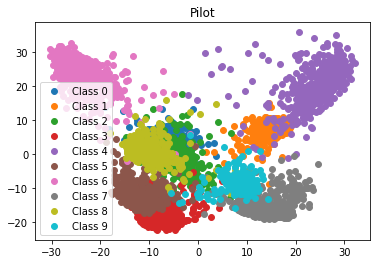

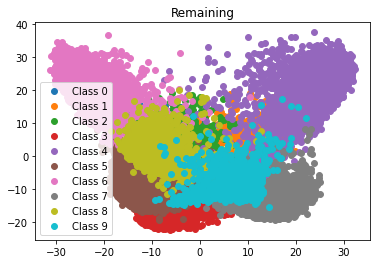

In [15]:
for k in range(K + 1):
    plt.scatter(pca_pilot[Y_pilot == k, 0], pca_pilot[Y_pilot == k, 1], s = 35, label = f"Class {k}")
plt.title("Pilot")
plt.legend()
plt.show()

for k in range(K + 1):
    plt.scatter(pca_rest[Y_rest == k, 0], pca_rest[Y_rest == k, 1], s = 35, label = f"Class {k}")
plt.title("Remaining")
plt.legend()
plt.show()

## MAC

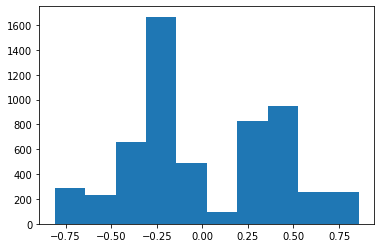

In [16]:
X_pilot = pca_pilot * 1.0
X_rest = pca_rest * 1.0
X_pilot = X_pilot * 1.0 / np.max(np.abs(X_pilot))
X_rest = X_rest * 1.0 / np.max(np.abs(X_rest))

plt.hist(X_pilot[:, 0])
plt.show()

In [17]:
X_pilot = add_constant(X_pilot)
X_rest = add_constant(X_rest)

In [18]:
n = X_pilot.shape[0]
p = X_pilot.shape[1]
M = crowd["CrowdID"].unique().shape[0]
print(n, p, K, M)

5721 8 9 10


In [19]:
crowd.head()

,TaskID,CrowdID,CrowdLabel
0,10,0,3
1,10,4,3
2,10,8,3
3,19,0,9
4,19,1,9


In [20]:
# A_pilot: Assignment Matrix
# AY_pilot: Crowd Label Matrix
# alpha_pilot: Assigment Probability Matrix
A_pilot, AY_pilot, alpha_pilot = assign(crowd)
alpha_n = np.mean(alpha_pilot)
print(alpha_n)

0.2626463904911729


In [21]:
init_model = Initial(X_pilot, AY_pilot, A_pilot, K)
init_beta, init_sigma, init_betams = init_model.init_param()

ts_model = MS(X_pilot, AY_pilot, A_pilot, K, alpha_pilot, init_beta, init_sigma)
ts_beta, ts_sigma = ts_model.update_alg(max_steps=2)

######## [Step 1] ########
norm(beta_gradient): 0.9339780
norm(sigma_gradient): 6.3156903
######## [Step 2] ########
norm(beta_gradient): 0.4767705


In [22]:
init_sigma, ts_sigma

(array([0.03271003, 0.03273793, 0.0330517 , 0.03314904, 0.03633193,
        0.03262398, 0.03307446, 0.03355488, 0.03320505, 0.03504025]),
 array([0.01373492, 0.0241534 , 0.0163145 , 0.01408831, 0.03873002,
        0.01853857, 0.0153615 , 0.02607383, 0.01329695, 0.02200876]))

In [23]:
beta_hat = np.zeros((K + 1, p))
beta_hat[1:] = ts_beta.reshape(K, p)

In [24]:
Avar = ts_model.compute_Avar(ts_model.beta, ts_sigma)
print(np.linalg.eigvals(Avar)[0])

169.83107173380037


In [25]:
np.linalg.eigvals(Avar)

array([1.69831072e+02, 1.07856665e+02, 9.65819299e+01, 5.78874546e+01,
       2.83371965e+01, 2.40155291e+01, 2.18361873e+01, 1.75198825e+01,
       1.62166782e+01, 1.53454713e+01, 1.45526396e+01, 1.36571045e+01,
       1.19931762e+01, 1.05256006e+01, 9.58229379e+00, 8.94798647e+00,
       8.33744659e+00, 7.95529792e+00, 6.77164528e+00, 6.76027860e+00,
       6.37498951e+00, 5.95541355e+00, 5.73104291e+00, 5.59880011e+00,
       5.09038924e+00, 5.00400784e+00, 4.62392020e+00, 4.35802390e+00,
       4.10511811e+00, 3.82106204e+00, 3.73922084e+00, 3.59315550e+00,
       3.53490682e+00, 3.34189233e+00, 3.09336185e+00, 2.96769951e+00,
       2.76683236e+00, 2.53625094e+00, 2.46596331e+00, 2.33192016e+00,
       2.11412574e+00, 1.95347303e+00, 1.91790886e+00, 1.73222833e+00,
       1.51480388e+00, 1.41918607e+00, 1.37829991e+00, 1.24107227e+00,
       1.23723310e+00, 1.13247950e+00, 1.10986049e+00, 1.04635575e+00,
       9.78008368e-01, 9.39850636e-01, 8.39258784e-01, 7.88934828e-01,
      

In [26]:
def compute_MaxMis_i(Xi, Yi, beta, Avar, n, M, alpha_n, K, p):
    """"""
    scale = np.sqrt(n * M * alpha_n)
    MaxMis_list = []
    j = Yi
    for k in range(K+1):
        if j == k:
            continue
        Avar_jk = get_Avar_jk(Avar, p, j, j) + get_Avar_jk(Avar, p, k, k) \
                  - get_Avar_jk(Avar, p, j, k) - get_Avar_jk(Avar, p, k, j)
        MaxMis = - scale * np.abs(Xi @ (beta[j] - beta[k])) / np.sqrt(np.abs(Xi @ Avar_jk @ Xi))
        MaxMis_list.append(MaxMis)

    MaxMis = max(MaxMis_list)
    return MaxMis

In [27]:
n = X_pilot.shape[0]
prob_pilot = X_pilot.dot(np.transpose(beta_hat))
Yhat_pilot = np.argmax(prob_pilot, axis=1)
MaxMis_pilot = [compute_MaxMis_i(X_pilot[i], Yhat_pilot[i], beta_hat, Avar, n, M, alpha_n, K, p) for i in range(n)]

n_rest = X_rest.shape[0]
prob_rest = X_rest.dot(np.transpose(beta_hat))
Yhat_rest = np.argmax(X_rest.dot(np.transpose(beta_hat)), axis=1)
MaxMis_rest = [compute_MaxMis_i(X_rest[i], Yhat_rest[i], beta_hat, Avar, n, M, alpha_n, K, p) for i in range(n_rest)]

0 0 -12.149649882078243
[ 0.         -0.12250541 -0.16586234 -0.1642306  -0.13900777 -0.0987011
 -0.08197272 -0.15798231 -0.08324215 -0.0974901 ]


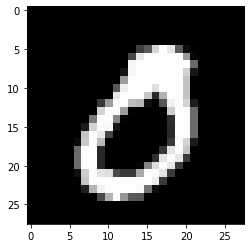

In [28]:
idx = 7
print(Y[id_pilot[idx]], Yhat_pilot[idx], MaxMis_pilot[idx])
print(prob_pilot[idx])
plt.imshow(X[id_pilot[idx]] / 255.0)
plt.show()

In [29]:
dat1 = pd.DataFrame({"Y": Y_pilot, "Yhat": Yhat_pilot, "MaxMis": MaxMis_pilot,})
dat2 = pd.DataFrame({"Y": Y_rest, "Yhat": Yhat_rest, "MaxMis": MaxMis_rest,})
dat = pd.concat([dat1, dat2], axis=0)
dat = dat.sort_values(by="MaxMis", ascending=False)
dat = dat.reset_index(drop=True)
dat["MaxMis_p"] = Phi(dat["MaxMis"])
dat["rank"] = np.arange(len(dat))
dat["mislabeled"] = (dat["Y"] != dat["Yhat"]).astype(int)

In [30]:
dat

,Y,Yhat,MaxMis,MaxMis_p,rank,mislabeled
0,5,3,-0.001146,4.995427e-01,0,1
1,4,1,-0.002564,4.989772e-01,1,1
2,2,1,-0.003756,4.985015e-01,2,1
3,3,7,-0.005637,4.977513e-01,3,1
4,0,0,-0.010693,4.957340e-01,4,0
...,...,...,...,...,...,...
59995,0,0,-14.123104,1.368324e-45,59995,0
59996,0,0,-14.124755,1.336644e-45,59996,0
59997,0,0,-14.148338,9.561233e-46,59997,0
59998,0,0,-14.154804,8.721182e-46,59998,0


In [31]:
N = len(dat)
print(N)
OMR = dat["mislabeled"].sum() / N
OMR

60000


0.012383333333333333

In [32]:
result = []

for w in [0.1, 0.05, 0.01]:
    human = dat[dat["MaxMis_p"] > w]
    machine = dat[dat["MaxMis_p"] <= w]
    ELC = human.shape[0] / N
    CMR = machine.mislabeled.sum() / machine.shape[0]
    result.append([w, CMR, ELC])

datDF = pd.DataFrame(result, columns=["omega", "CMR", "ELC"])

In [33]:
datDF

,omega,CMR,ELC
0,0.10,0.009030,0.007033
1,0.05,0.008207,0.008933
2,0.01,0.006754,0.012867
